In [1]:
path_datos = "gs://bucket-tfm-llc/datos"

# Librerias

In [2]:
import pyspark.sql.functions as F

import seaborn as sns
import matplotlib.pyplot as plt
import math

# Lectura tablas

In [3]:
fec_inicio = "2019-01-01"
fec_fin = "2025-01-01"

output_name = "datos_financieros_amzn_cleaned_19_25"

In [4]:
datos_financieros = spark.read.parquet(f"{path_datos}/datos_financieros_amzn_trat").\
                          filter(F.col("date") >= fec_inicio).filter(F.col("date") < fec_fin)

# Funciones

In [5]:
def plot_boxplots(df_input, list_vars, var_target = "target", n_cols = 6):
  df = df_input.toPandas()
  n_vars = len(list_vars)
  rows = math.ceil(n_vars / n_cols)

  fig, axs = plt.subplots(nrows= rows, ncols= n_cols, figsize=(n_cols * 4, rows * 4))
  axs = axs.flatten()

  for i, var in enumerate(list_vars):
      sns.boxplot(x=df[var_target], y=df[var], ax=axs[i], color = "lightblue")
      axs[i].set_title(var)

  # Quitar ejes vacíos si sobran
  for j in range(i + 1, len(axs)):
      fig.delaxes(axs[j])

  plt.tight_layout()
  plt.show()

In [6]:
def num_outliers_IQR(df, list_vars, threshold=3):
  outliers_info = []

  for var in list_vars:
      q1, q3 = df.approxQuantile(var, [0.25, 0.75], 0.01)
      iqr = q3 - q1
      lower = q1 - threshold * iqr
      upper = q3 + threshold * iqr

      total = df.count()
      outliers_count = df.filter((F.col(var) < lower) | (F.col(var) > upper)).count()
      outlier_pct = 100 * (outliers_count / total)

      outliers_info.append({
          'feature': var,
          'outliers': outliers_count,
          'percent': outlier_pct,
          'lower_bound': lower,
          'upper_bound': upper
      })
  return spark.createDataFrame(outliers_info)

In [7]:
def wins_out_IQR(df, list_vars, threshold=3):
  df_out = df
  for var in list_vars:
    q1, q3 = df.approxQuantile(var, [0.25, 0.75], 0.01)
    iqr = q3 - q1
    lower = q1 - threshold * iqr
    upper = q3 + threshold * iqr

    # df_out = df_filtrado.filter((F.col(var)>= lower) & (F.col(var) <= upper))
    df_out = df_out.withColumn(var, F.when(F.col(var) < lower, lower).when(F.col(var) > upper, upper).otherwise(F.col(var)))

  return df_out

# EDA

In [8]:
datos_financieros.count()

1510

In [9]:
datos_financieros.printSchema()

root
 |-- date: timestamp (nullable = true)
 |-- open: double (nullable = true)
 |-- high: double (nullable = true)
 |-- low: double (nullable = true)
 |-- close: double (nullable = true)
 |-- volume: double (nullable = true)
 |-- target: integer (nullable = true)
 |-- roc_5d: double (nullable = true)
 |-- roc_10d: double (nullable = true)
 |-- roc_20d: double (nullable = true)
 |-- roc_50d: double (nullable = true)
 |-- roc_100d: double (nullable = true)
 |-- roc_200d: double (nullable = true)
 |-- ma_5d: double (nullable = true)
 |-- ma_10d: double (nullable = true)
 |-- ma_20d: double (nullable = true)
 |-- ma_50d: double (nullable = true)
 |-- ma_100d: double (nullable = true)
 |-- ma_200d: double (nullable = true)
 |-- boll_upper_20d: double (nullable = true)
 |-- boll_lower_20d: double (nullable = true)
 |-- zscore_5d: double (nullable = true)
 |-- zscore_10d: double (nullable = true)
 |-- zscore_20d: double (nullable = true)
 |-- zscore_50d: double (nullable = true)
 |-- zscore_

In [10]:
# Resumen estadístico:
datos_financieros.summary().show()

In [11]:
# Valores nulos:
datos_financieros.select([F.sum(F.col(var).isNull().cast("int")).alias(var) for var in datos_financieros.columns]).show()

+----+----+----+---+-----+------+------+------+-------+-------+-------+--------+--------+-----+------+------+------+-------+-------+--------------+--------------+---------+----------+----------+----------+-----------+-----------+-------------+-------------+--------------+---------------+-------------------+-------------------+--------------------+---------------------+-------------+--------------+--------------+------+-------+-------+--------+-------+-------------+--------------+--------------+---------------+----------------+----------------+----------+------+-------+-------+-------------+--------------+--------------+-------------+--------------+--------------+-------+--------+--------+-----------+------------+-----+------------+
|date|open|high|low|close|volume|target|roc_5d|roc_10d|roc_20d|roc_50d|roc_100d|roc_200d|ma_5d|ma_10d|ma_20d|ma_50d|ma_100d|ma_200d|boll_upper_20d|boll_lower_20d|zscore_5d|zscore_10d|zscore_20d|zscore_50d|zscore_100d|zscore_200d|ma_10d_vs_20d|ma_20d_vs_50d|m

In [12]:
# # Eliminamos valores nulos: (Como no hay, no es necesario)
# datos_financieros = datos_financieros.dropna()
# datos_financieros.select([F.sum(F.col(var).isNull().cast("int")).alias(var) for var in datos_financieros.columns]).show()

# Variables originales

In [13]:
vars_originales = ["open", "high", "low",  "close", "volume"]

In [14]:
datos_financieros.select(vars_originales).summary().show()

+-------+------------------+-----------------+------------------+------------------+--------------------+
|summary|              open|             high|               low|             close|              volume|
+-------+------------------+-----------------+------------------+------------------+--------------------+
|  count|              1510|             1510|              1510|              1510|                1510|
|   mean|1571.3821071523212|1589.295652052981|1551.7500334437045|1570.6765430463536|2.5665760822516557E7|
| stddev|1343.6001350445188|1358.828224102811|1326.3092352967337|1342.2905270563197| 2.960645162917518E7|
|    min|              82.8|            83.48|             81.43|             81.82|            881337.0|
|    25%|             146.0|         147.5999|             145.3|            146.74|           3346227.0|
|    50%|           1773.33|           1787.5|            1755.0|           1773.42|           5899094.0|
|    75%|         3098.2713|          3132.89|

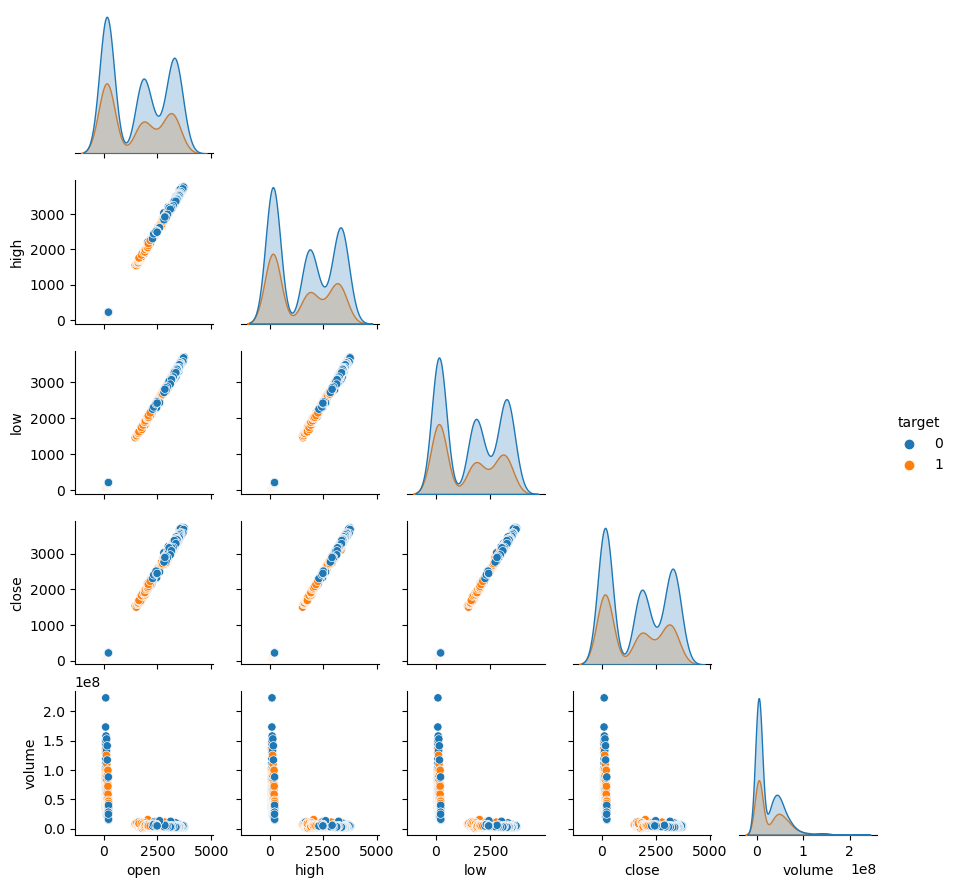

In [15]:
sns.pairplot(datos_financieros.toPandas()[vars_originales + ["target"]], corner=True, hue = "target", height = 1.8, aspect=1)
# plt.suptitle("Distribuciones y correlaciones - Variables originales", y=1.02)
plt.show()

In [16]:
# plt.savefig("/content/drive/MyDrive/TFM/imagenes/matriz_correlacion_originales.png", dpi=300, bbox_inches='tight')

## Target

In [17]:
datos_financieros.groupBy("target").agg(F.count("*").alias("num_casos")).show()

+------+---------+
|target|num_casos|
+------+---------+
|     1|      505|
|     0|     1005|
+------+---------+



In [18]:
for var in datos_financieros.columns:
    if var != "target" and datos_financieros.schema[var].dataType.simpleString() in ["double", "int"]:
        corr = datos_financieros.stat.corr(var, "target")
        print(f"{var}: {corr}")


open: -0.06319243109592833
high: -0.06306022523153113
low: -0.06357035882285801
close: -0.06358440204629119
volume: 0.06058994650131461
roc_5d: 0.0034775197677476754
roc_10d: -0.06382933717523576
roc_20d: -0.055775032312581796
roc_50d: -0.06593241016850836
roc_100d: -0.007801890739527578
roc_200d: -0.0008275058435046953
ma_5d: -0.06495927565579593
ma_10d: -0.0636625730059065
ma_20d: -0.05988355794092993
ma_50d: -0.05078328810202428
ma_100d: -0.05250408371094265
ma_200d: -0.06083376290865482
boll_upper_20d: -0.05572699666127825
boll_lower_20d: -0.06289309500508766
zscore_5d: -0.00983567832635094
zscore_10d: -0.052783408475585276
zscore_20d: -0.041972519048725614
zscore_50d: -0.10553995608000552
zscore_100d: -0.061696096382763486
zscore_200d: -0.04684930046868579
ma_10d_vs_20d: 0.060473277783760826
ma_20d_vs_50d: 0.07489019241477449
ma_50d_vs_100d: -0.0025965838117095077
ma_100d_vs_200d: -0.01782981894681325
cross_ma_10d_vs_20d: -0.03048328806075192
cross_ma_20d_vs_50d: -0.10986100193468

## Variables temporales

In [19]:
# Variables temporales
vars_tmp = ["day_of_week","day_of_month","month","week_of_year"]
datos_financieros.select(vars_tmp).summary().show()

+-------+------------------+-----------------+------------------+------------------+
|summary|       day_of_week|     day_of_month|             month|      week_of_year|
+-------+------------------+-----------------+------------------+------------------+
|  count|              1510|             1510|              1510|              1510|
|   mean| 4.024503311258278| 15.7158940397351| 6.547019867549669|26.631788079470198|
| stddev|1.3986866360342143|8.767867057553435|3.4320210443569823| 14.98449108057372|
|    min|                 2|                1|                 1|                 1|
|    25%|                 3|                8|                 4|                14|
|    50%|                 4|               16|                 7|                27|
|    75%|                 5|               23|                10|                40|
|    max|                 6|               31|                12|                53|
+-------+------------------+-----------------+------------------+

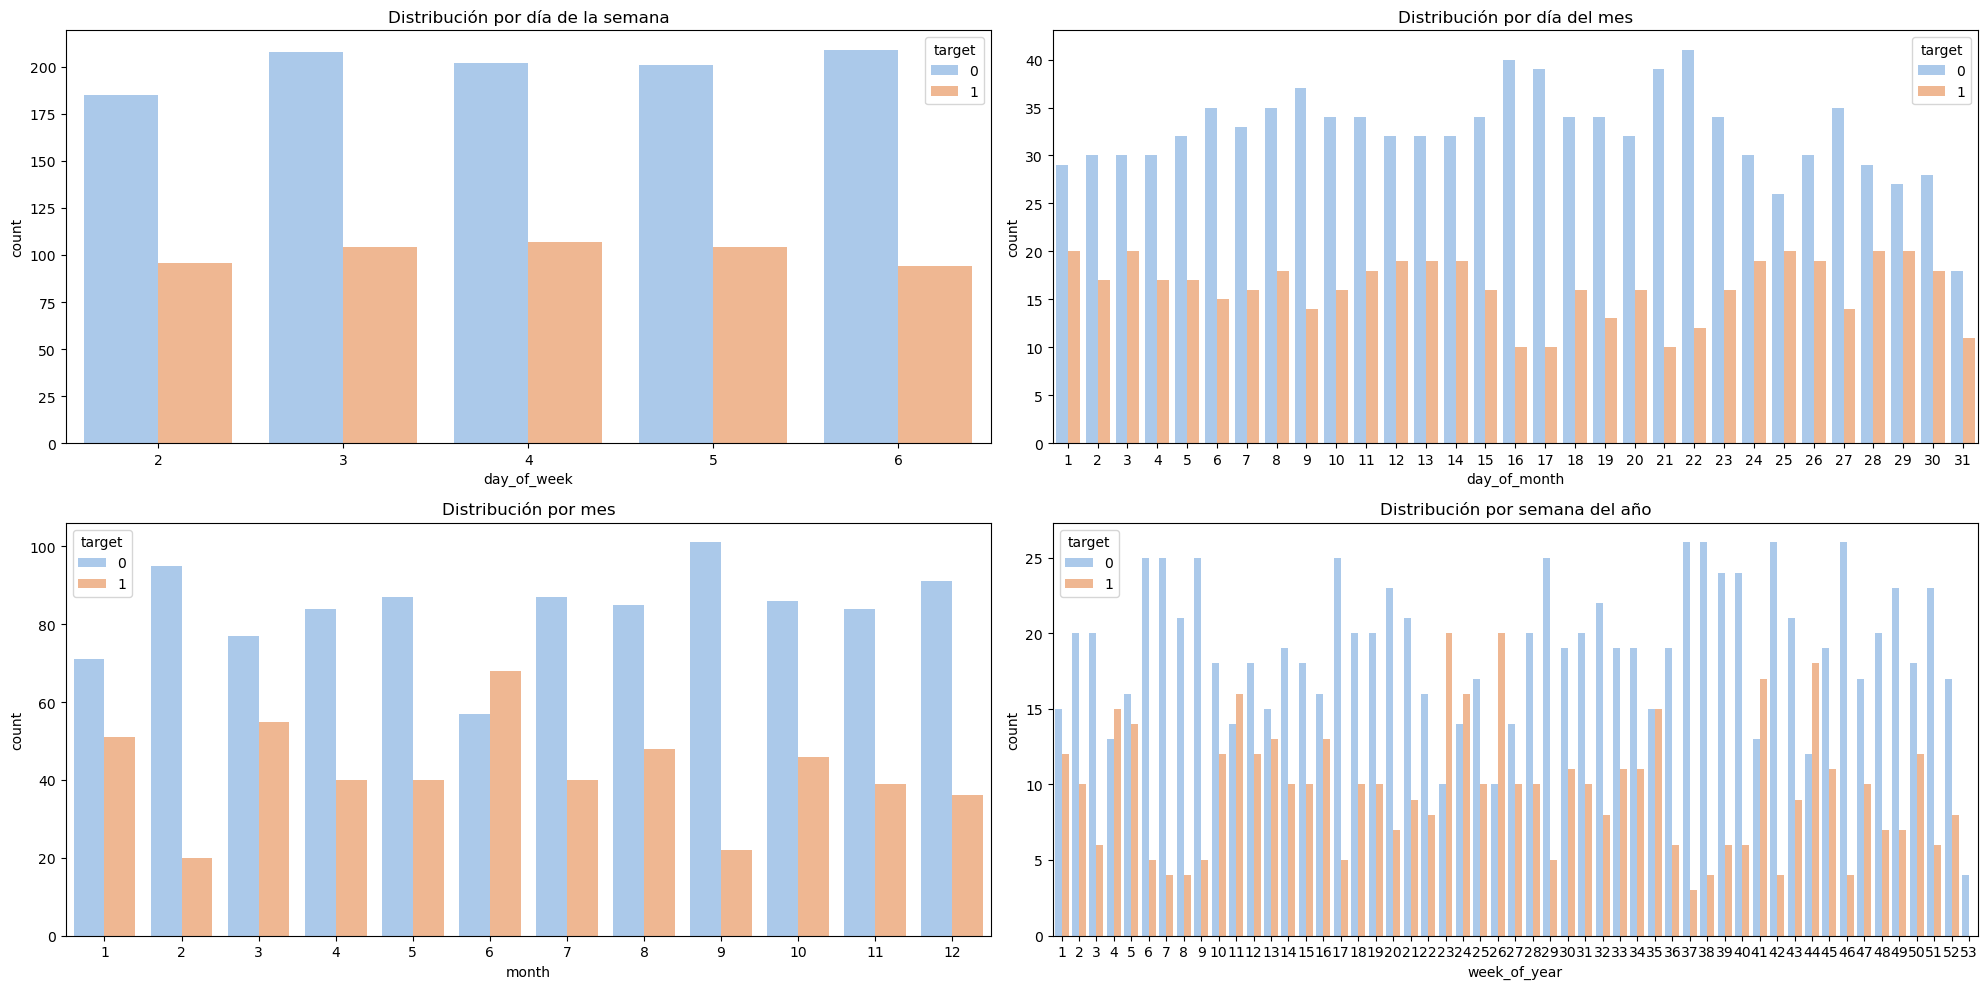

In [20]:
fig, axes = plt.subplots(2, 2, figsize=(20, 10))

sns.countplot(data=datos_financieros.toPandas(), x="day_of_week", hue="target", ax=axes[0, 0], palette = "pastel")
axes[0, 0].set_title("Distribución por día de la semana")

sns.countplot(data=datos_financieros.toPandas(), x="day_of_month", hue="target", ax=axes[0, 1], palette = "pastel")
axes[0, 1].set_title("Distribución por día del mes")

sns.countplot(data=datos_financieros.toPandas(), x="month", hue="target", ax=axes[1, 0],  palette = "pastel")
axes[1, 0].set_title("Distribución por mes")

sns.countplot(data=datos_financieros.toPandas(), x="week_of_year", hue="target", ax=axes[1, 1],  palette = "pastel")
axes[1, 1].set_title("Distribución por semana del año")

plt.tight_layout()
plt.show()

## Tendencia

In [21]:
vars_roc = [var for var in datos_financieros.columns if var.startswith("roc_")]
vars_ma = [var for var in datos_financieros.columns if (var.startswith("ma_")) & (var.find("_vs_") == -1)]
vars_boll = [var for var in datos_financieros.columns if var.startswith("boll_")]
vars_zscore = [var for var in datos_financieros.columns if var.startswith("zscore_")]

vars_rel_ma = [var for var in datos_financieros.columns if ((var.startswith("ma_")) & (var.find("_vs_") > -1)) | (var.startswith("cross_")) ]

<AxesSubplot:>

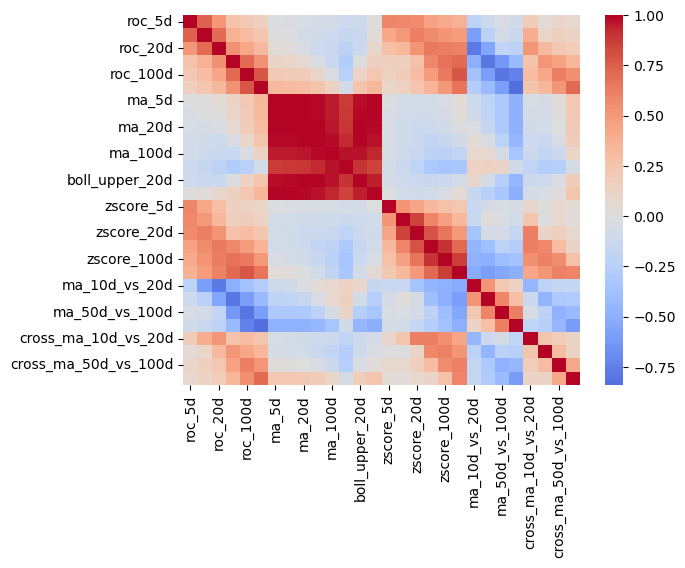

In [22]:
df_corr = datos_financieros.toPandas()
list_vars_tendencia = vars_roc + vars_ma + vars_boll + vars_zscore + vars_rel_ma
sns.heatmap(df_corr[list_vars_tendencia].corr(), cmap="coolwarm", center=0)

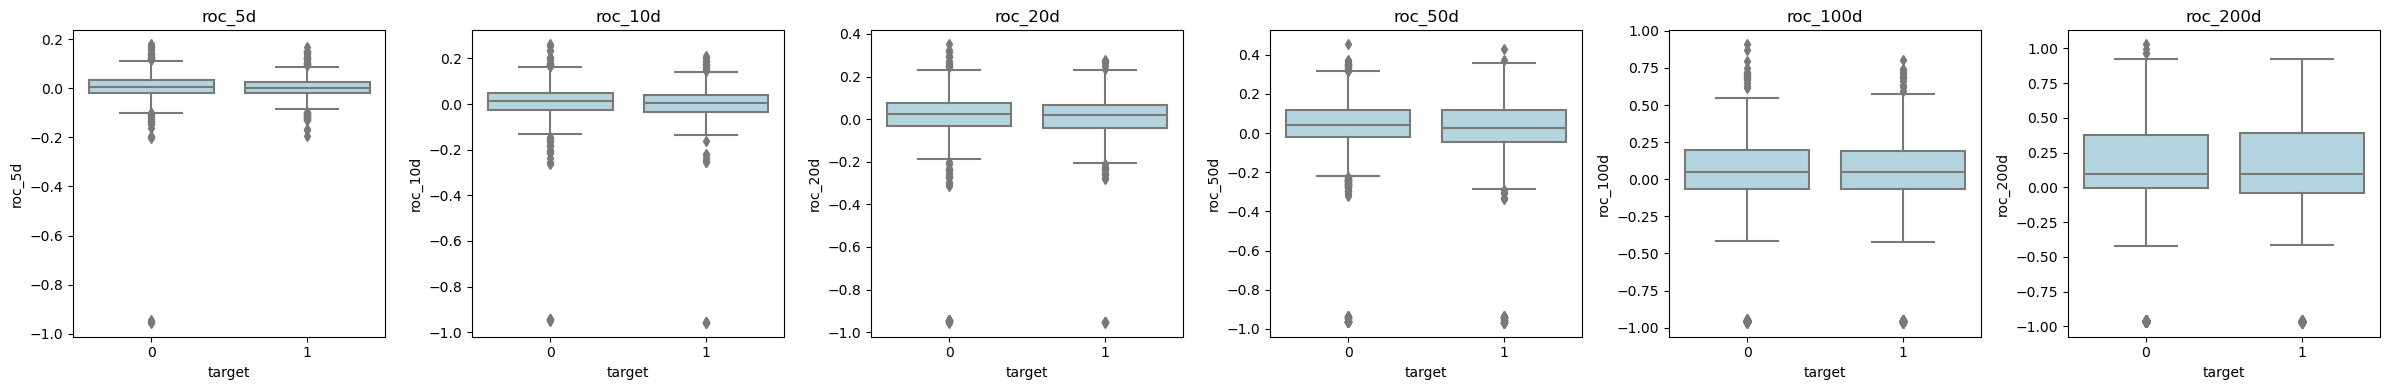

In [23]:
# plot_boxplots(wins_out_IQR(datos_financieros, vars_roc), vars_roc)
plot_boxplots(datos_financieros, vars_roc)

In [24]:
num_outliers_IQR(datos_financieros, vars_roc).show()

+--------+--------------------+--------+------------------+-------------------+
| feature|         lower_bound|outliers|           percent|        upper_bound|
+--------+--------------------+--------+------------------+-------------------+
|  roc_5d| -0.1717764309976002|       9|0.5960264900662252|0.18178243408715297|
| roc_10d| -0.2490803355383096|      14|0.9271523178807948| 0.2656803377202593|
| roc_20d| -0.3500637981750458|      20|1.3245033112582782| 0.3863973572829793|
| roc_50d|-0.44352450843613955|      50|3.3112582781456954| 0.5331935294439052|
|roc_100d| -0.8518116451539907|     100| 6.622516556291391| 0.9790667682987786|
|roc_200d| -1.2039388275196414|       0|               0.0| 1.5634589651068398|
+--------+--------------------+--------+------------------+-------------------+



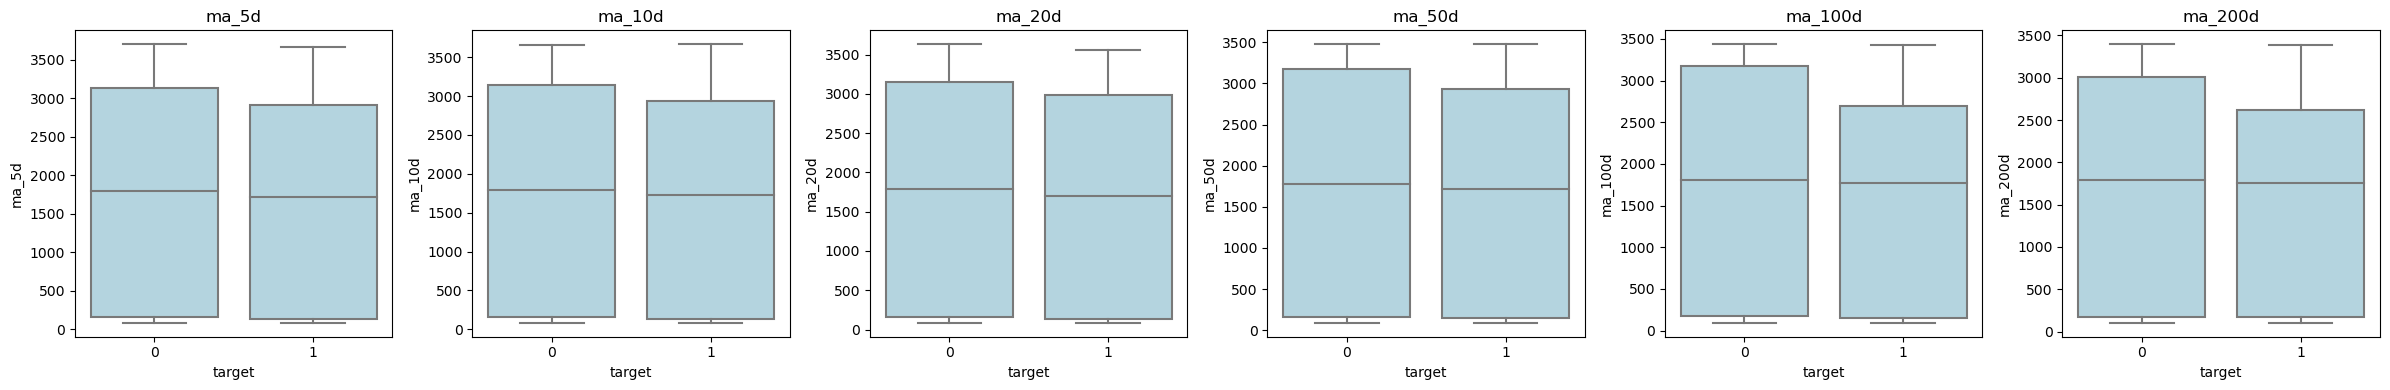

In [25]:
plot_boxplots(datos_financieros, vars_ma)

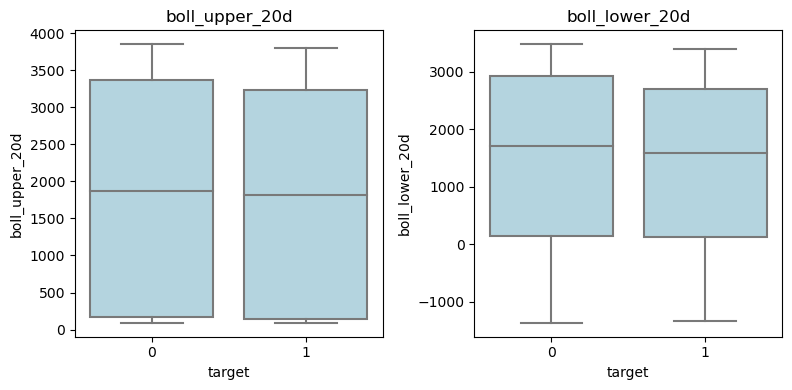

In [26]:
plot_boxplots(datos_financieros, vars_boll)

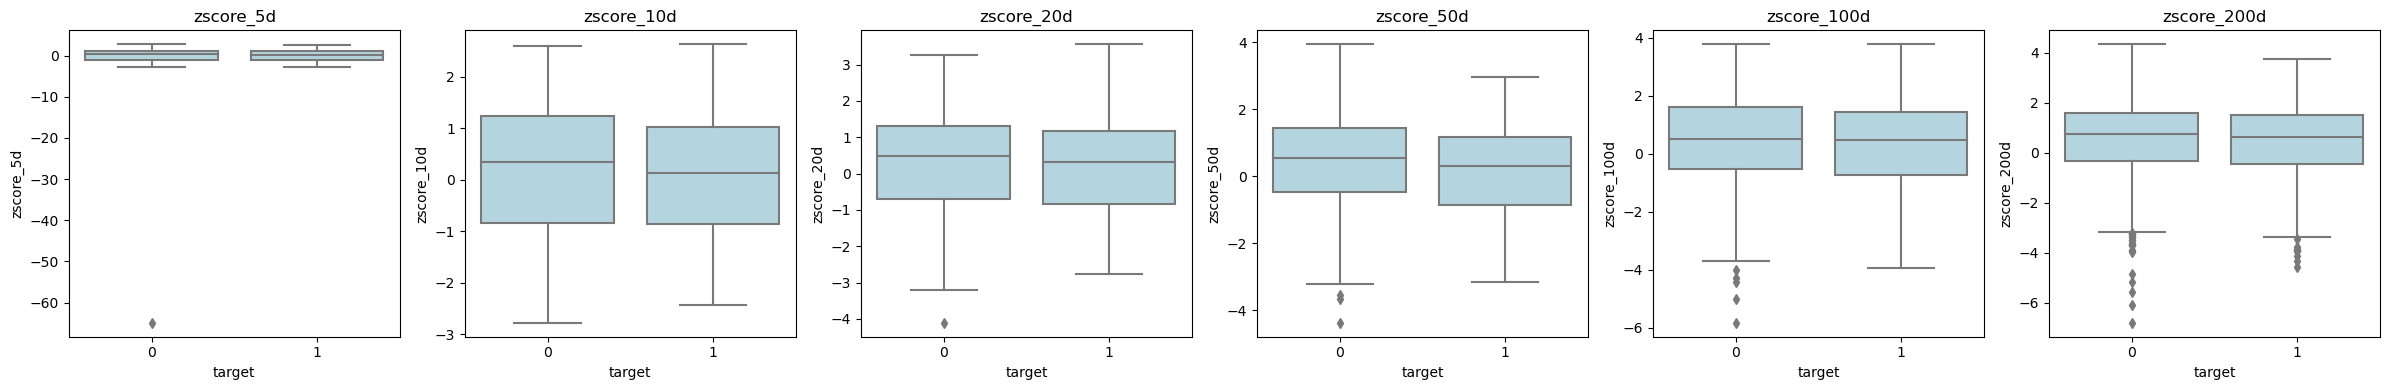

In [27]:
plot_boxplots(datos_financieros, vars_zscore)

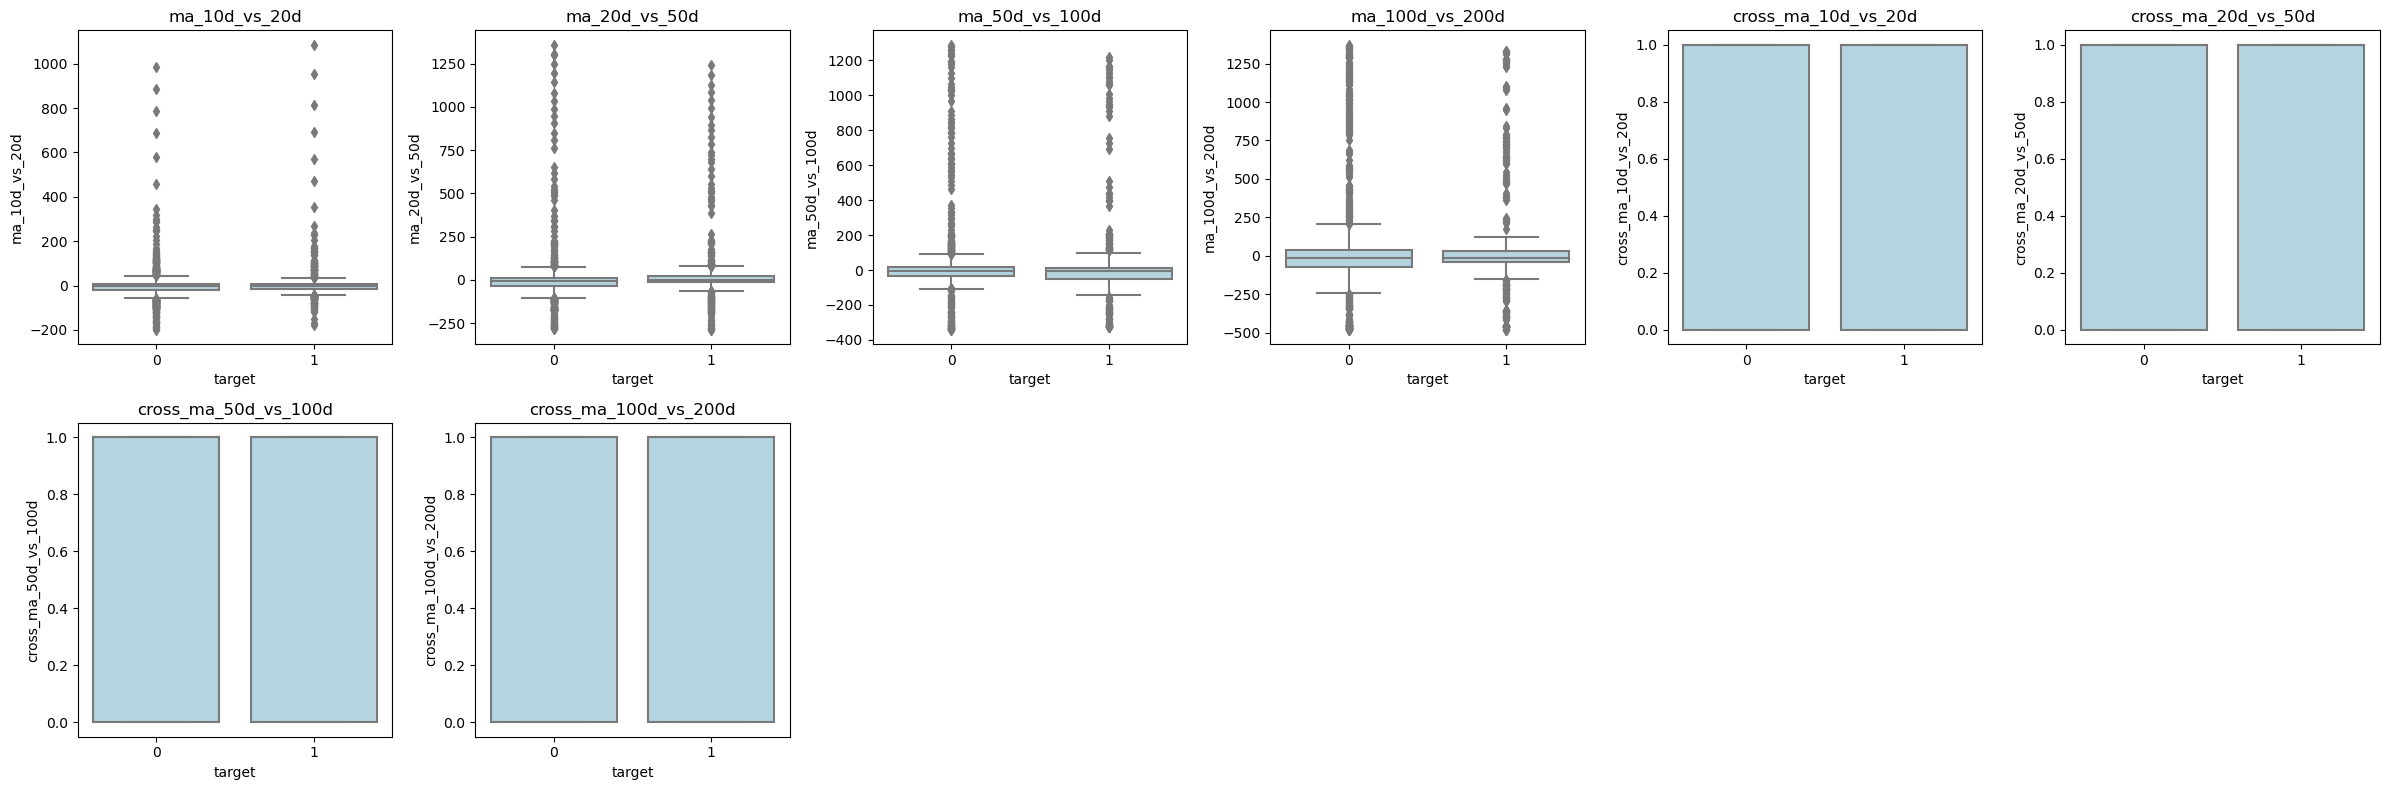

In [28]:
plot_boxplots(datos_financieros, vars_rel_ma)

In [29]:
num_outliers_IQR(datos_financieros, vars_rel_ma).show()

+--------------------+-------------------+--------+------------------+------------------+
|             feature|        lower_bound|outliers|           percent|       upper_bound|
+--------------------+-------------------+--------+------------------+------------------+
|       ma_10d_vs_20d| -86.47749999999772|     203|13.443708609271523| 74.85149999999828|
|       ma_20d_vs_50d|-138.21230000000185|     208|13.774834437086092| 122.5216000000014|
|      ma_50d_vs_100d|-178.88479999999845|     211|13.973509933774833|158.63630000000012|
|     ma_100d_vs_200d| -348.8489499999937|     264|17.483443708609272| 317.3378999999941|
| cross_ma_10d_vs_20d|               -3.0|       0|               0.0|               4.0|
| cross_ma_20d_vs_50d|               -3.0|       0|               0.0|               4.0|
|cross_ma_50d_vs_100d|               -3.0|       0|               0.0|               4.0|
|cross_ma_100d_vs_...|               -3.0|       0|               0.0|               4.0|
+---------

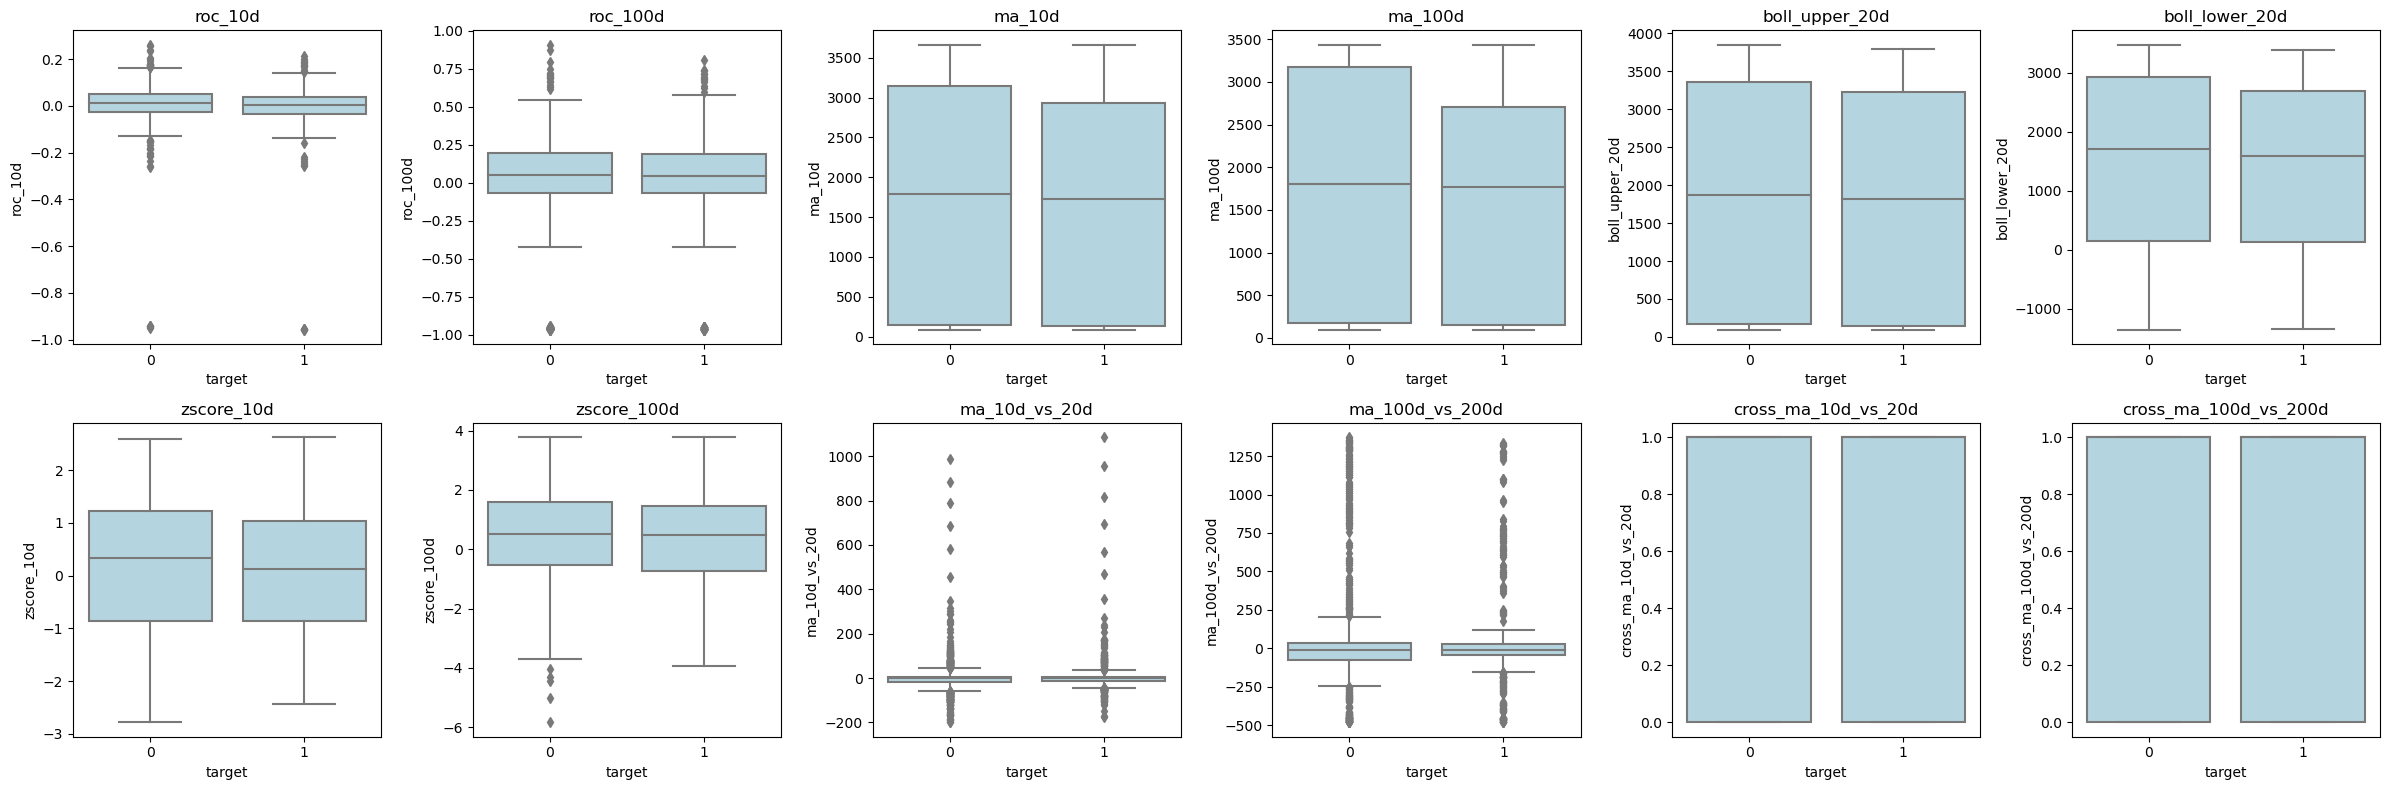

In [30]:
# Resumen
vars_resumen_tendencia = ["roc_10d","roc_100d","ma_10d","ma_100d"] + vars_boll + ["zscore_10d","zscore_100d", "ma_10d_vs_20d", "ma_100d_vs_200d", "cross_ma_10d_vs_20d", "cross_ma_100d_vs_200d"]
plot_boxplots(datos_financieros, vars_resumen_tendencia)

## Volatilidad

In [31]:
vars_volatilidad = [var for var in datos_financieros.columns if (var.startswith("volatility_")) | (var.startswith("atr_")) | (var.startswith("gap"))]

<AxesSubplot:>

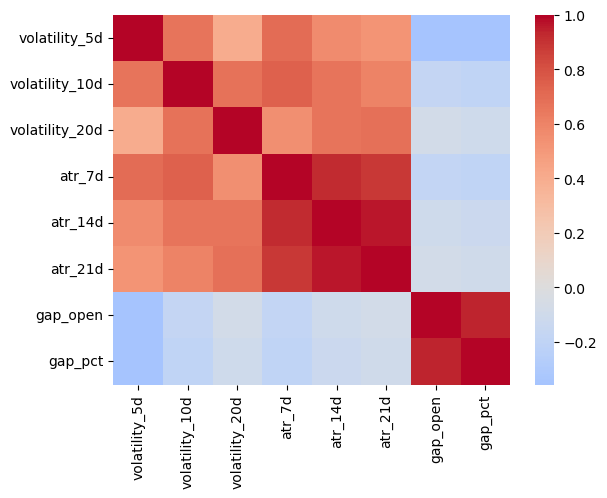

In [32]:
sns.heatmap(df_corr[vars_volatilidad].corr(), cmap="coolwarm", center=0)

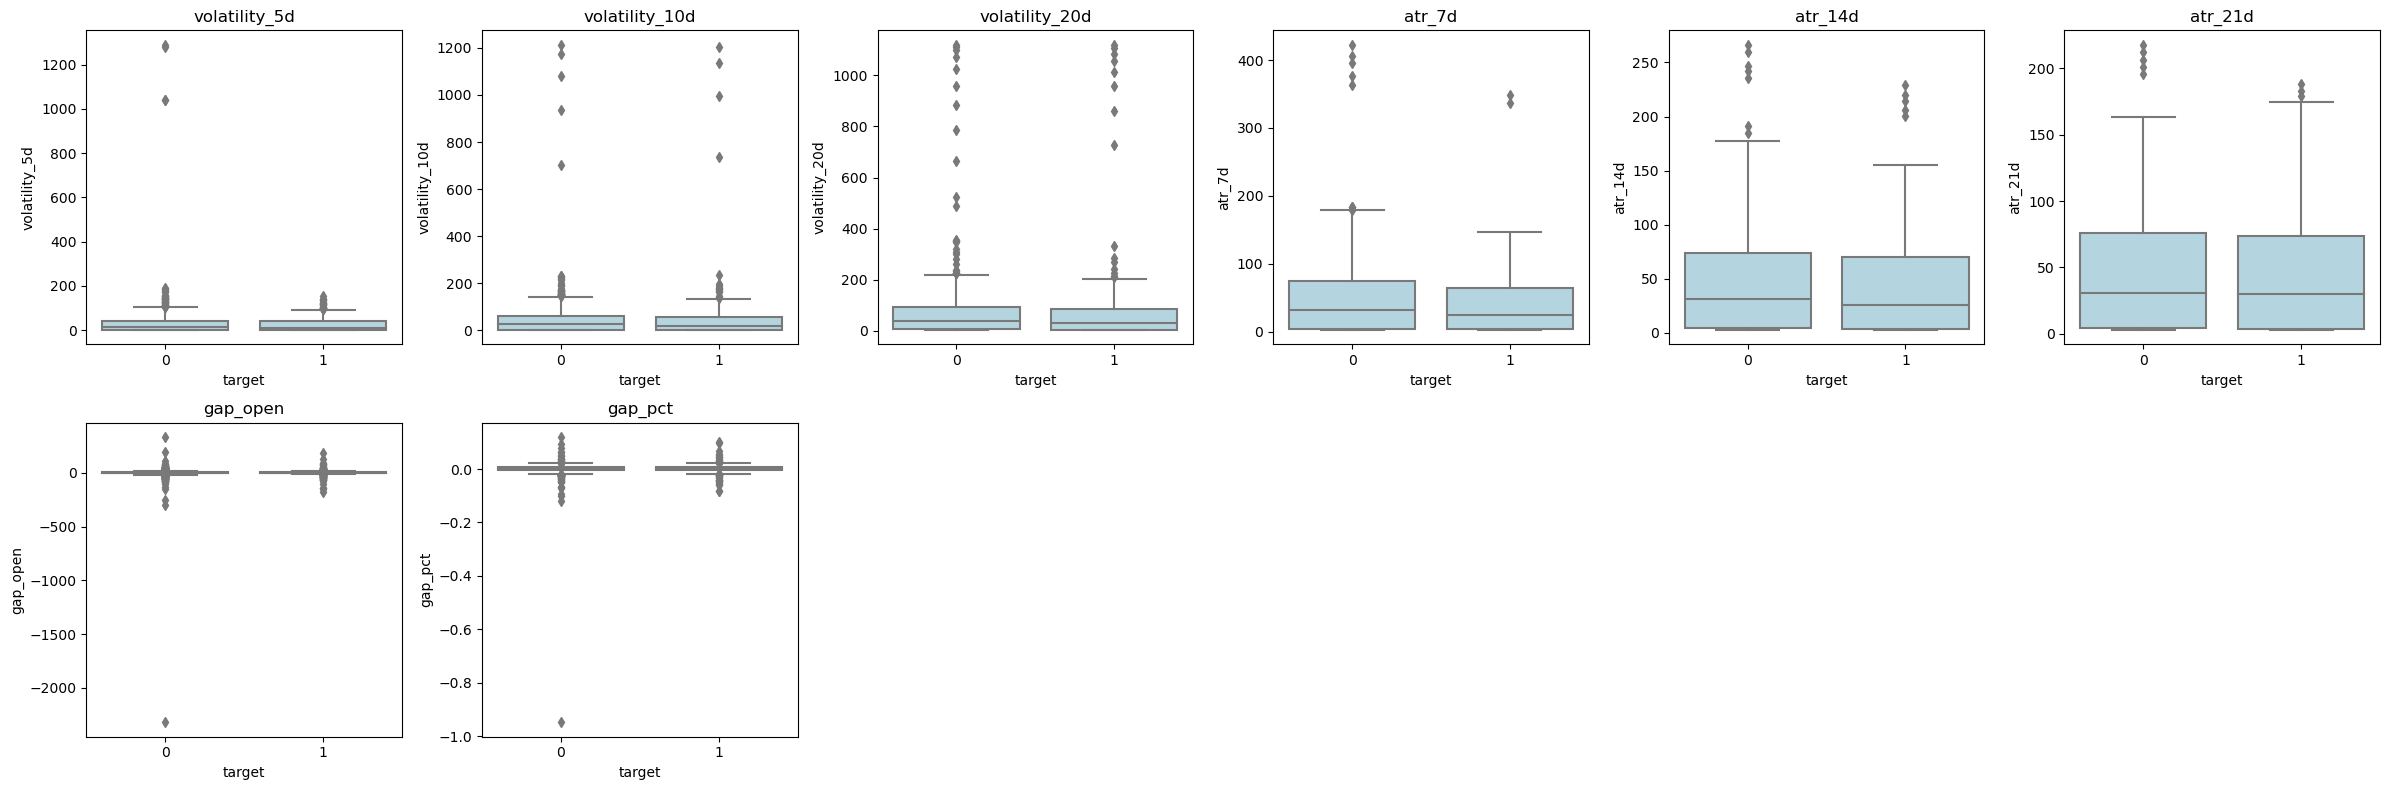

In [33]:
plot_boxplots(datos_financieros, vars_volatilidad)

In [34]:
num_outliers_IQR(datos_financieros, vars_volatilidad).show()

+--------------+--------------------+--------+------------------+--------------------+
|       feature|         lower_bound|outliers|           percent|         upper_bound|
+--------------+--------------------+--------+------------------+--------------------+
| volatility_5d| -115.27676922818655|      10|0.6622516556291391|   159.5086094343767|
|volatility_10d| -160.24281195261733|      14|0.9271523178807948|   221.7785907116318|
|volatility_20d|  -242.9592793857398|      23|1.5231788079470199|  335.50029711125933|
|        atr_7d| -193.19594285714302|       7|0.4635761589403974|  267.01125714285735|
|       atr_14d| -198.15865000000025|       0|               0.0|   273.8273500000003|
|       atr_21d| -206.76350000000005|       0|               0.0|  285.21766666666673|
|      gap_open| -24.009999999999877|     191|12.649006622516556|  28.139999999999844|
|       gap_pct|-0.03432618549886...|      45| 2.980132450331126|0.036666683401114064|
+--------------+--------------------+------

# Volumen

In [35]:
vars_volume = [var for var in datos_financieros.columns if var.startswith("volume_")] + ["money_flow"]

<AxesSubplot:>

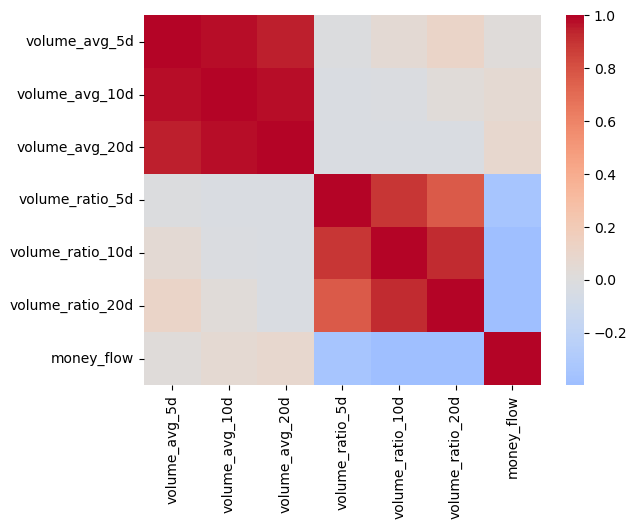

In [36]:
sns.heatmap(df_corr[vars_volume].corr(), cmap="coolwarm", center=0)

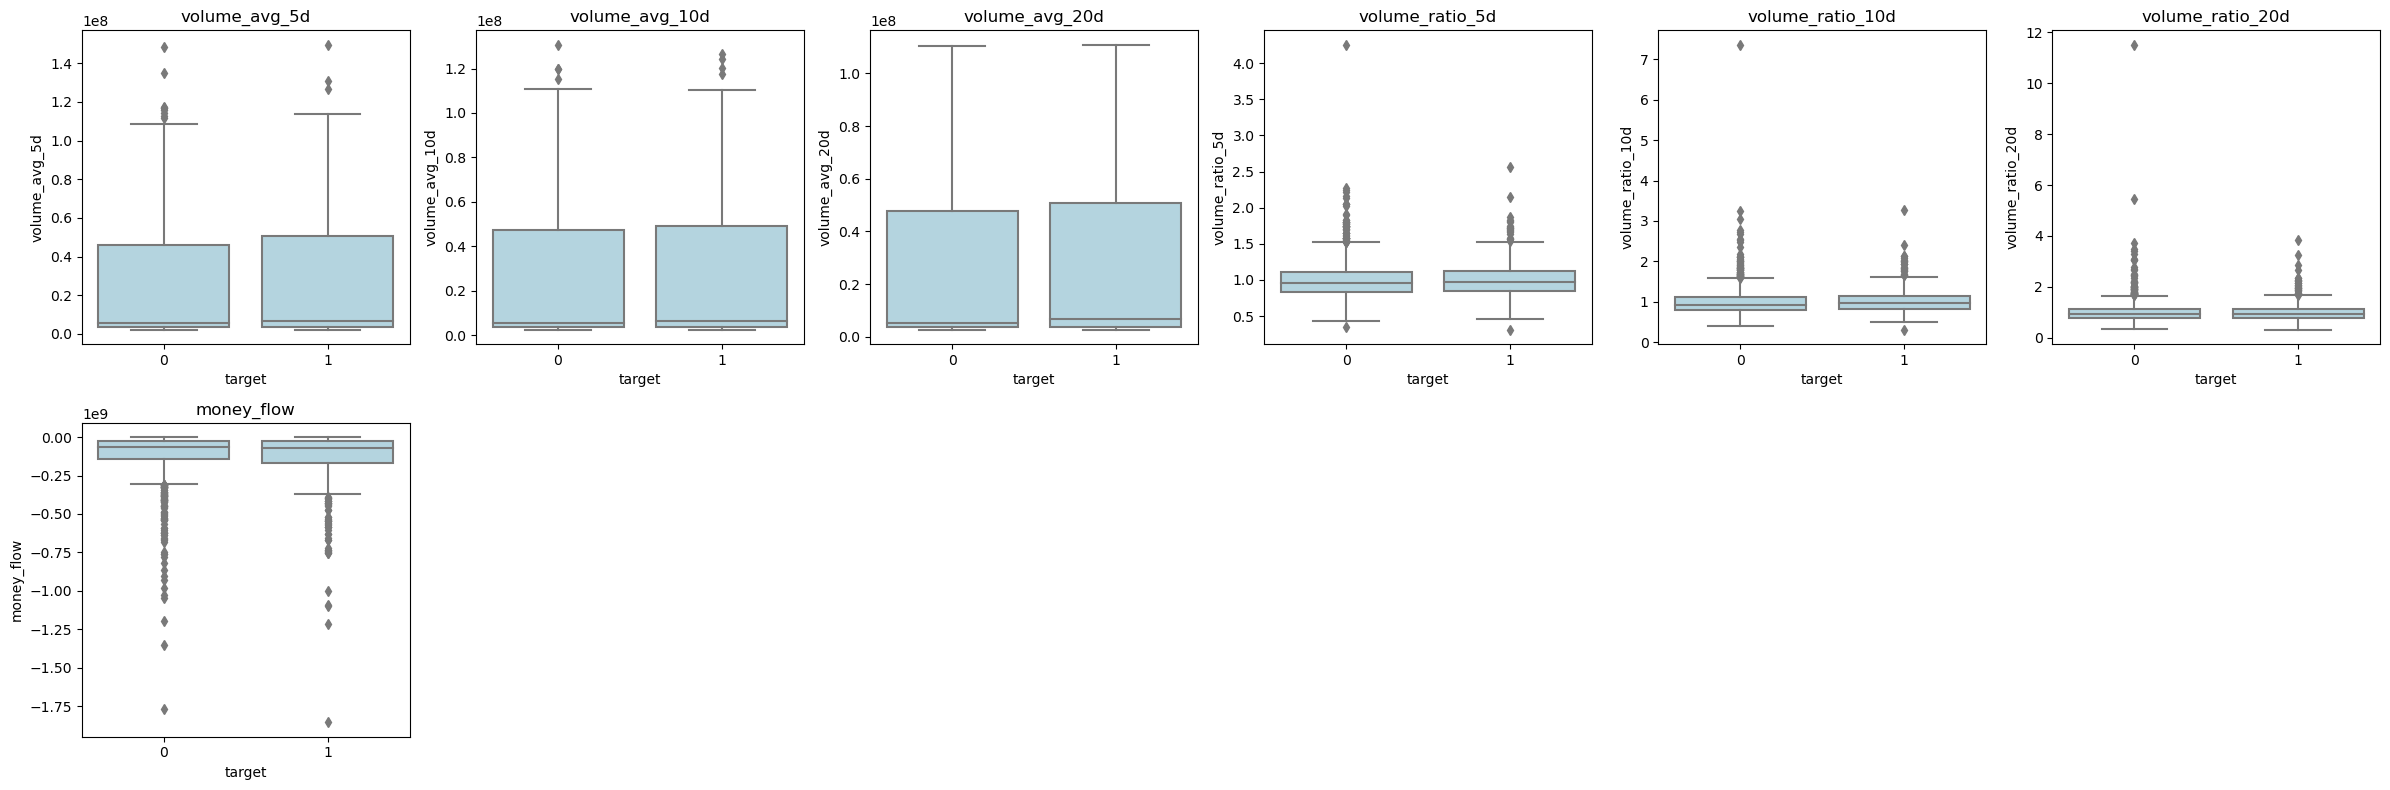

In [37]:
plot_boxplots(datos_financieros, vars_volume)

In [38]:
num_outliers_IQR(datos_financieros, vars_volume).show()

+----------------+--------------------+--------+------------------+--------------------+
|         feature|         lower_bound|outliers|           percent|         upper_bound|
+----------------+--------------------+--------+------------------+--------------------+
|   volume_avg_5d|-1.27101777799999...|       0|               0.0|        1.77762519E8|
|  volume_avg_10d|-1.29128518499999...|       0|               0.0|1.8052210879999998E8|
|  volume_avg_20d|-1.30157241600000...|       0|               0.0|       1.820393235E8|
| volume_ratio_5d| 0.04404417702201968|      13|0.8609271523178808|  1.9057969434080424|
|volume_ratio_10d|-0.11533861527757905|      22| 1.456953642384106|    2.03601174461579|
|volume_ratio_20d|  -0.272665350384489|      31| 2.052980132450331|   2.170550866913342|
|      money_flow|-5.007060044499987E8|      68| 4.503311258278146| 3.271808344199989E8|
+----------------+--------------------+--------+------------------+--------------------+



# Momentum y osciladores

In [39]:
vars_rsi = [var for var in datos_financieros.columns if (var.startswith("rsi_")) | (var.startswith("change_rsi_"))]
vars_will = [var for var in datos_financieros.columns if var.startswith("williams_")]
vars_eo = [var for var in datos_financieros.columns if var.startswith("eo_k_")]

<AxesSubplot:>

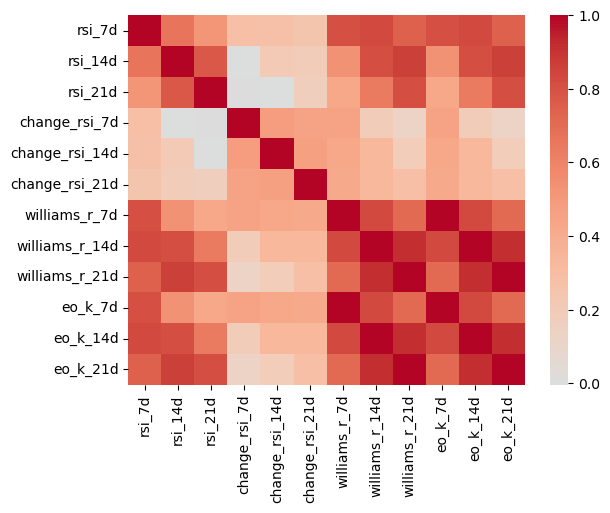

In [40]:
vars_momentum = vars_rsi + vars_will + vars_eo
sns.heatmap(df_corr[vars_momentum].corr(), cmap="coolwarm", center=0)

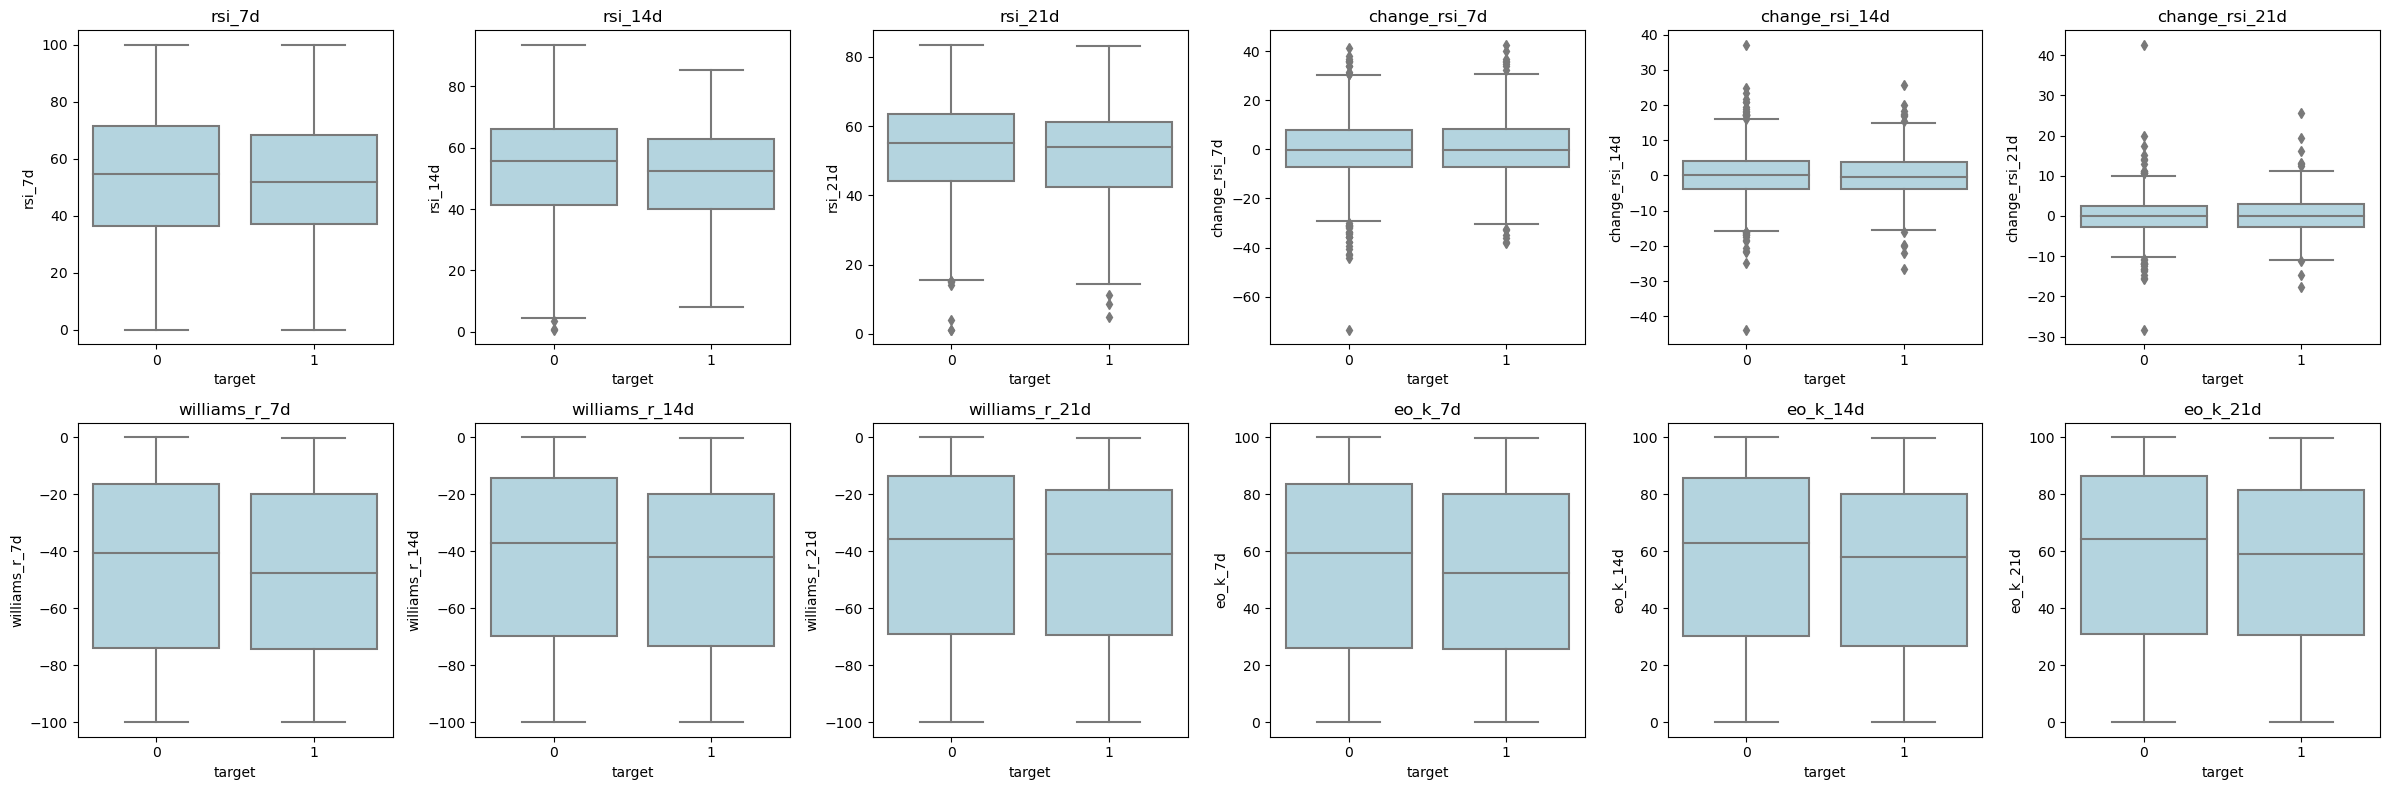

In [41]:
plot_boxplots(datos_financieros, vars_rsi + vars_will + vars_eo)

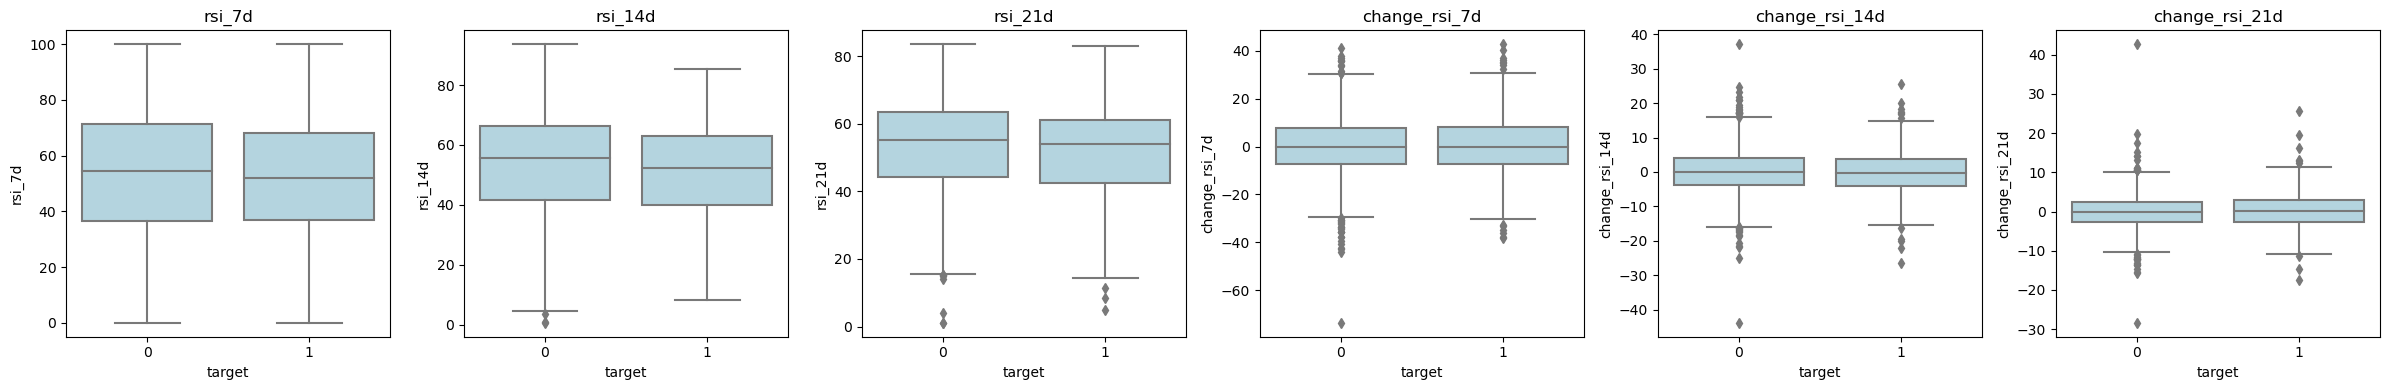

In [42]:
plot_boxplots(datos_financieros, vars_rsi)

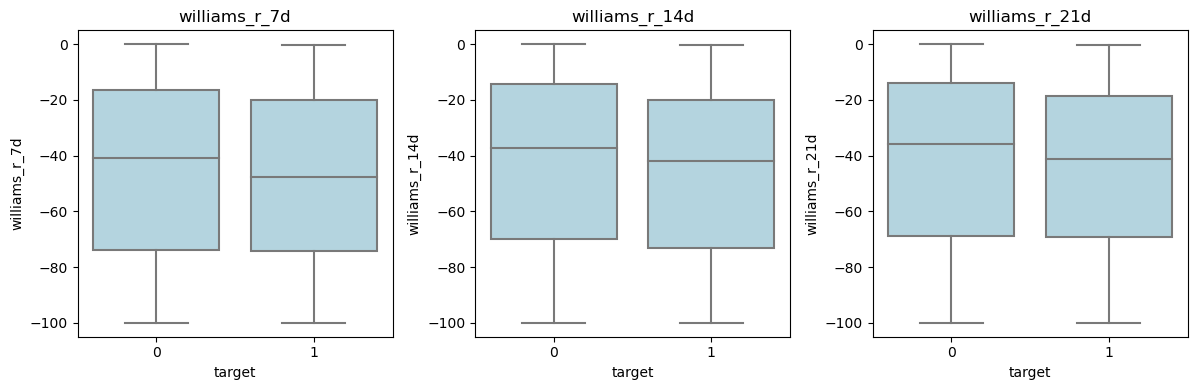

In [43]:
plot_boxplots(datos_financieros, vars_will)

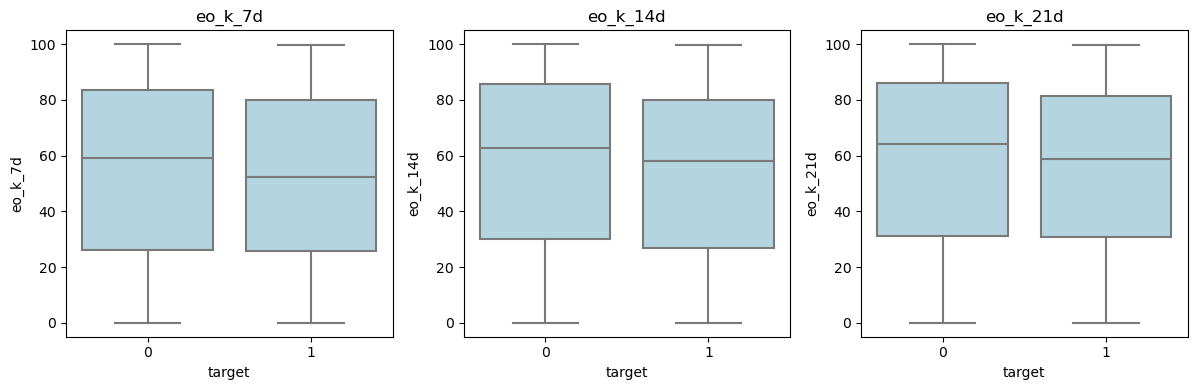

In [44]:
plot_boxplots(datos_financieros, vars_eo)

# Output

In [45]:
datos_financieros.write.mode("overwrite").format("parquet").save(f"{path_datos}/{output_name}")